Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Step 1: Minibatch Loss: 0.446994
Step 1000: Minibatch Loss: 0.151266
Step 2000: Minibatch Loss: 0.145203
Step 3000: Minibatch Loss: 0.144123
Step 4000: Minibatch Loss: 0.142944
Step 5000: Minibatch Loss: 0.138330
Step 6000: Minibatch Loss: 0.137754
Step 7000: Minibatch Loss: 0.140968
Step 8000: Minibatch Loss: 0.136567
Step 9000: Minibatch Loss: 0.133045
Step 10000: Minibatch Loss: 0.130651
Step 11000: Minibatch Loss: 0.128096
Step 12000: Minibatch Loss: 0.124576
Step 13000: Minibatch Loss: 0.123757
Step 14000: Minibatch Loss: 0.121421
Step 15000: Minibatch Loss: 0.118793
Step 16000: Minibatch Loss: 0.118087
Step 17000: Minibatch Loss: 0.115139
Step 18000: Minibatch Loss: 0.113086
Step 19000: Minibatch Loss: 0.112615
Step 20000: Minibatch Loss: 0.111535
Step 21000: Minibatch Loss: 0.110521
Step 2200

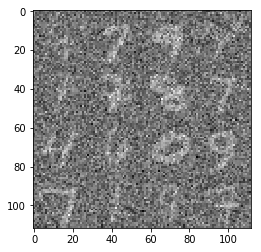

Reconstructed Images


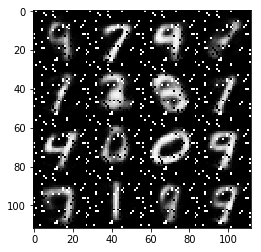

In [46]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


# Training Parameters
learning_rate = 0.001
num_steps = 100000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
x_noisy = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(x_noisy)
decoder_op = decoder(encoder_op)
#decoder_op = decoder(X)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

noise_level = 0.6

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x_noisy = batch_x + noise_level * np.random.normal(loc=0.0, scale=1.0, size=batch_x.shape)

        # Run optimization op (backprop) and cost op (to get loss value)
        #_, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        #feed_dict_batch = {x_noisy: batch_x_noisy, X: batch_x}
        feed_dict_batch = {X: batch_x, x_noisy: batch_x_noisy}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict_batch)
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        batch_x_noisy = batch_x + noise_level * np.random.normal(loc=0.0, scale=1.0, size=batch_x.shape)
        feed_dict_batch = {X: batch_x, x_noisy: batch_x_noisy}
        g = sess.run(decoder_op, feed_dict=feed_dict_batch)

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x_noisy[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

In [20]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
%matplotlib inline

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
x_noisy = tf.placeholder("float", [None, num_input])

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
len(X)

In [25]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    #'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    #'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [26]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
    #                               biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h2']),
                                   biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return layer_1


In [27]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

Step 1: Minibatch Loss: 0.440548
Step 1000: Minibatch Loss: 0.059003
Step 2000: Minibatch Loss: 0.048682
Step 3000: Minibatch Loss: 0.042994
Step 4000: Minibatch Loss: 0.041236
Step 5000: Minibatch Loss: 0.041086
Step 6000: Minibatch Loss: 0.039205
Step 7000: Minibatch Loss: 0.040305
Step 8000: Minibatch Loss: 0.040904
Step 9000: Minibatch Loss: 0.039587
Step 10000: Minibatch Loss: 0.038845
Step 11000: Minibatch Loss: 0.038540
Step 12000: Minibatch Loss: 0.035429
Step 13000: Minibatch Loss: 0.036284
Step 14000: Minibatch Loss: 0.035339
Step 15000: Minibatch Loss: 0.035816
Step 16000: Minibatch Loss: 0.035734
Step 17000: Minibatch Loss: 0.035251
Step 18000: Minibatch Loss: 0.034567
Step 19000: Minibatch Loss: 0.035027
Step 20000: Minibatch Loss: 0.036068
Step 21000: Minibatch Loss: 0.035159
Step 22000: Minibatch Loss: 0.033655
Step 23000: Minibatch Loss: 0.032207
Step 24000: Minibatch Loss: 0.032587
Step 25000: Minibatch Loss: 0.032734
Step 26000: Minibatch Loss: 0.031701
Step 27000: Mi

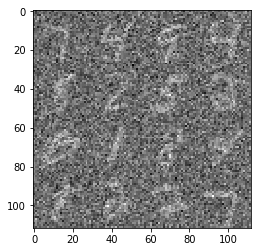

Reconstructed Images


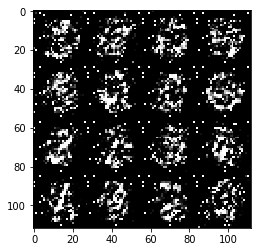

In [28]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

noise_level = 0.6

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x_noisy = batch_x + noise_level * np.random.normal(loc=0.0, scale=1.0, size=batch_x.shape)

        # Run optimization op (backprop) and cost op (to get loss value)
        #_, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        feed_dict_batch = {X: batch_x, x_noisy: batch_x_noisy}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict_batch)
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        batch_x_noisy = batch_x + noise_level * np.random.normal(loc=0.0, scale=1.0, size=batch_x.shape)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x_noisy})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x_noisy[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()